# Alarm data - *Data Exploration*

## Input

#### Imports

In [1]:
import pandas as pd
import numpy as np
import collections
import datetime
from dateutil.relativedelta import relativedelta
from calendar import monthrange
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use = 'default' 

#### Data

In [2]:
# Read data
files = ["../Data_Acetate/acetateAlarms.csv","../Data_Acetate/acetateAlarmsTr.csv"]
dfs = [pd.read_csv(f,encoding="utf-8-sig") for f in files]
dfs[0]['System'] = "Acetate"
dfs[1]['System'] = "Tracing"

df = pd.concat(dfs)
#print("#alarms = {}".format(df['Message'].count()))
#df.head(5)

In [3]:
# Transform data
if 'State' in df.columns:
    df = df[df['State']==1]                                         
    del df['State']
if 'Timestamp' in df.columns:    
    df['Date'] = df['Timestamp'].map(lambda x: x.split(' ')[0])     
    df['Time'] = df['Timestamp'].map(lambda x: x.split(' ')[1])
    del df['Timestamp']
    
#print("#alarms = {}".format(df['Message'].count()))
#df.head(5)

In [4]:
# Filter data
df = df[df['Class']=='Error']
del df['Class']
#df.sort_values(by=['Date','Time'],inplace=True)

print("#alarms = {}".format(df['Message'].count()))
df.head(5)

#alarms = 2074


Message            Id   Type  \
0  TT-300-7-004: TEMPERATUURMETING PRODUCT TANK 3...  TT-300-7-004  Alarm   
2  TT-300-7-004: TEMPERATUURMETING PRODUCT TANK 3...  TT-300-7-004  Alarm   
4  TT-300-7-004: TEMPERATUURMETING PRODUCT TANK 3...  TT-300-7-004  Alarm   
6  TT-250-5-004: TEMPERATUURMETING PRODUCT TANK 2...  TT-250-5-004  Alarm   
7  T250-5-ET1: TEMPERATUUR VLOEISTOF ENTIS TANK 2...    T250-5-ET1  Alarm   

    Group   System        Date      Time  
0  T300-7  Acetate  2016-03-20  07:27:16  
2  T300-7  Acetate  2016-03-20  07:27:56  
4  T300-7  Acetate  2016-03-20  07:28:07  
6  T250-5  Acetate  2016-03-20  12:41:09  
7  T250-5  Acetate  2016-03-20  13:01:03

In [5]:
df.describe().loc['count':'unique','Message':'Date']

Message    Id  Type Group System  Date
count     2074  2074  2074  2074   2074  2074
unique     206   149     2    38      2   123

## Exploration

In [9]:
def Data(df_x,key,col='count',srt='count',mrg=False):
    ct_x = pd.crosstab(index=df_x[key],columns=(df_x[col] if col!='count' else col),margins=mrg)
    if srt: ct_x.sort_values(by=srt,ascending=False,inplace=True)
    return ct_x

def Plot(df_x,ct_x,key,th=5,sz=(7.5,5),sc=True,st=False):
    ''' th= threshold, sz= size, sc= system colors, st= stack plot
    '''
    data = ct_x[ct_x.values>=th] if th else ct_x
    sc = SystemColors(df_x,data,key) if sc else None
    
    plt.figure(figsize=sz)
    ax = plt.subplot(1,1,1)                                                 
    data.plot.bar(ax=ax, stacked=st, color=sc, title="#alarms per {}".format(key))
    ax.legend().set_visible(False)
    plt.xlabel('')
    plt.yticks(rotation='vertical')
    plt.show()
    return

def SystemColors(df_x,ct_x,key):
    colormap = {'Acetate':'b','Tracing':'g'}
    colors = list()
    for x in ct_x.index:
        y = df_x[df_x[key]==x]['System'].iloc[0]
        if y in colormap:
            colors.append(colormap[y])
        else:
            colors.append('r')
    return colors

#### Message

In [10]:
x = df[df['System']=='Tracing']
y = df[df['System']=='Acetate']
print(x.groupby('Message').size().count())
print(y.groupby('Message').size().count())


76
130


In [11]:
# Data
ct = Data(df,'Message')
ct.head(3)

col_0                                               count
Message                                                  
TTWW-420-03-003: TEMPERATUURMETING WARMWATER UN...    223
TTWW-420-02-003: TEMPERATUURMETING WARMWATER UN...    132
TTWW-420-03-003: TEMPERATUURMETING WARMWATER UN...    131

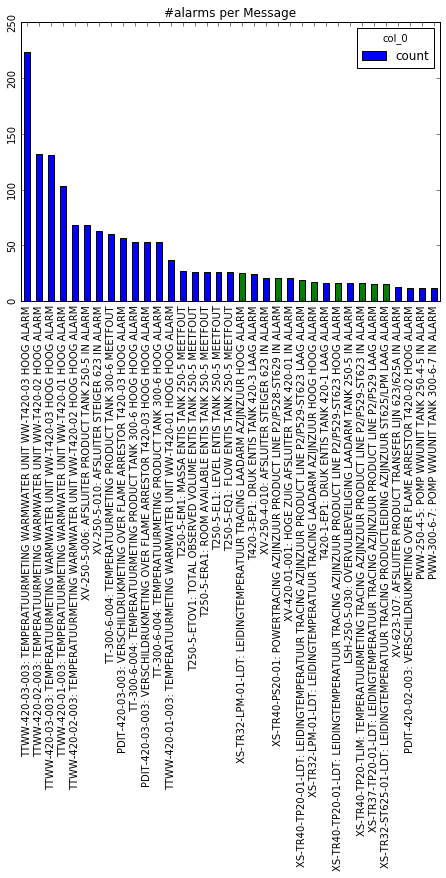

In [12]:
# Graph
Plot(df,ct,'Message',th=12)

#### ID

In [10]:
# Data
ct = Data(df,'Id')
ct.head(3)

col_0            count
Id                    
TTWW-420-03-003    354
TTWW-420-02-003    200
TT-300-6-004       166

In [11]:
# Graph
Plot(df,ct,'Id',th=12)

#### Group

In [12]:
# Data
ct = Data(df,'Group')
ct.head(3)

col_0            count
Group                 
Warm water unit    758
T250-5             233
T300-6             173

In [13]:
# Graph
Plot(df,ct,'Group',th=12)

#### Type

In [13]:
#Data
ct = Data(df,'Type',col='System',srt='Acetate')
ct.columns = ['Acetate','Tracing']
ct.index = ['Alarm','ESD_Alarm']
ct

Acetate  Tracing
Alarm         1720      349
ESD_Alarm        5        0

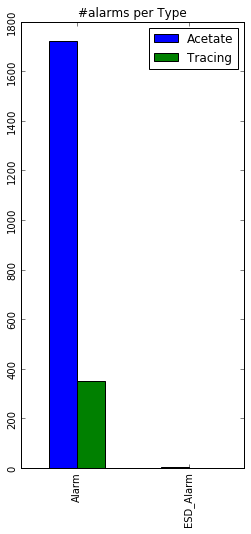

In [14]:
# Graph
Plot(None,ct,'Type',th=None,sz=(4,8),sc=False)

#### Date 

In [16]:
def MonthRange (data,month):
    m = [int(x) for x in month.split('-')]
    _,r = monthrange(m[0],m[1])
    r = [(month + '-' + str(x).zfill(2)) for x in range(1,r+1)]
    for x in r:
        if x not in data.index:
            data.loc[x] = 0
    return data

def Plots(cts_x,sz=(10,4),st=False):
    for i,x in enumerate(cts_x):
        plt.figure(i,figsize=sz)
        ax = plt.subplot(1,1,1) 
        cts_x[x].plot.bar(ax=ax,stacked=st,title='Alarms per day for {}'.format(x))     
        ax.set_xticklabels([int(y.split('-')[-1]) for y in cts_x[x].index])
        plt.yticks(range(0,100,10))
        plt.xticks(rotation='horizontal')
        #ax.axhline(dfs_date[x].mean(), color='r',linewidth=2)   
        plt.ylabel('# Alarms')    
    plt.show()
    return

In [17]:
# Data
gr = df.groupby(df['Date'].map(lambda x: x.split('-')[0]+'-'+x.split('-')[1]))
dfs = {x:gr.get_group(x).copy() for x in gr.groups}
dfs = collections.OrderedDict(sorted(dfs.items(), key=lambda x: x[0]))
dfs['2015-11'].head(3)

Message                Id  \
251  TTWW-420-03-003: TEMPERATUURMETING WARMWATER U...   TTWW-420-03-003   
252  TTWW-420-03-003: TEMPERATUURMETING WARMWATER U...   TTWW-420-03-003   
257     FT-250-5-AL-INIT: INITIALISATIE ALARM IN ALARM  FT-250-5-AL-INIT   

      Type            Group   System        Date      Time  
251  Alarm  Warm water unit  Acetate  2015-11-17  00:02:50  
252  Alarm  Warm water unit  Acetate  2015-11-17  00:35:13  
257  Alarm             LP1A  Acetate  2015-11-17  10:37:10

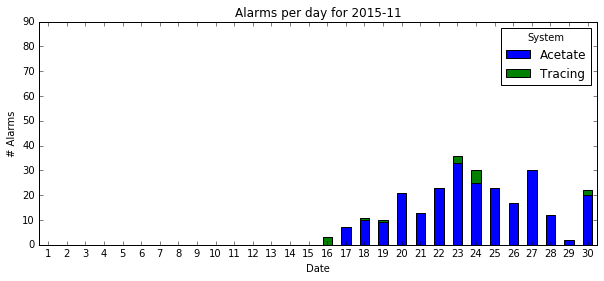

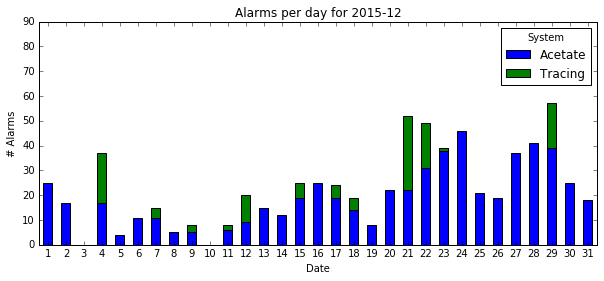

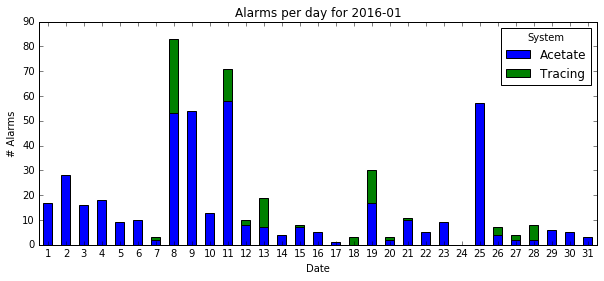

In [18]:
cts = {x:Data(dfs[x],'Date',col='System',srt=None) for x in dfs.keys()}
cts = collections.OrderedDict(sorted(cts.items(), key=lambda x: x[0]))

for x in cts:
    cts[x] = MonthRange(cts[x],x)
    cts[x].sort_index(inplace=True)

Plots(cts,st=True)